# Regularized Logistic Reggression from scratch

## Case Study - Whether microchips from a fabrication plant passes quality assurance (QA)

###  Necessary imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.optimize as opt

### Load local data into the program

In [2]:
def load_data(path):
    data = pd.read_csv(path, header = None)
    
    return data

data = load_data("data.txt")

### Data Pre-processing

In [3]:
X = data.iloc[0:data.shape[0],0:2]

m = X.shape[0]         # Training samples

X_test = data.iloc[m:data.shape[0],0:2]
X_test = np.c_[np.ones((data.shape[0]-m,1)), X_test]

y = np.array(data.iloc[0:m,2]).reshape((m,1))
y_test = np.array(data.iloc[m:data.shape[0],2]).reshape((data.shape[0]-m,1))

X = np.c_[np.ones((m,1)), X]
theta = np.array(np.zeros((X.shape[1],1)))

admitted = data.iloc[0:m,:].loc[ y == 1 ]                        
admitted = np.array(admitted.iloc[:, 0:2])

not_admitted = data.iloc[0:m,:].loc[ y == 0 ]
not_admitted = np.array(not_admitted.iloc[:, 0:2])

### Feature Scaling - Normalization

In [4]:
_X = np.array(np.zeros((X.shape)))
_admitted = np.array(np.zeros((admitted.shape)))
_not_admitted = np.array(np.zeros((not_admitted.shape)))

x1_avg = np.sum(X[:,1])/m
x1_range = np.max(X[:,1]) - np.min(X[:,1])

x2_avg = np.sum(X[:,2])/m
x2_range = np.max(X[:,2]) - np.min(X[:,2])

_X[:,1] = (X[:,1] - x1_avg)/x1_range
_X[:,2] = (X[:,2] - x2_avg)/x2_range


ad_x1_avg = np.sum(admitted[:,0])/m
ad_x1_range = np.max(admitted[:,0]) - np.min(admitted[:,0])

ad_x2_avg = np.sum(admitted[:,1])/m
ad_x2_range = np.max(admitted[:,1]) - np.min(admitted[:,1])

_admitted[:,0] = (admitted[:,0] - ad_x1_avg)/ad_x1_range
_admitted[:,1] = (admitted[:,1]- ad_x2_avg)/ad_x2_range

nad_x1_avg = np.sum(not_admitted[:,0])/m
nad_x1_range = np.max(not_admitted[:,0]) - np.min(admitted[:,0])

nad_x2_avg = np.sum(not_admitted[:,1])/m
nad_x2_range = np.max(not_admitted[:,1]) - np.min(admitted[:,1])

_not_admitted[:,0] = (not_admitted[:,0] - nad_x1_avg)/nad_x1_range
_not_admitted[:,1] = (not_admitted[:,1]- nad_x2_avg)/nad_x2_range

### Important Observation - Normalization mixes up samples
### So we'll prefer using un-normalised data for more general sense for CLASSIFICATION 

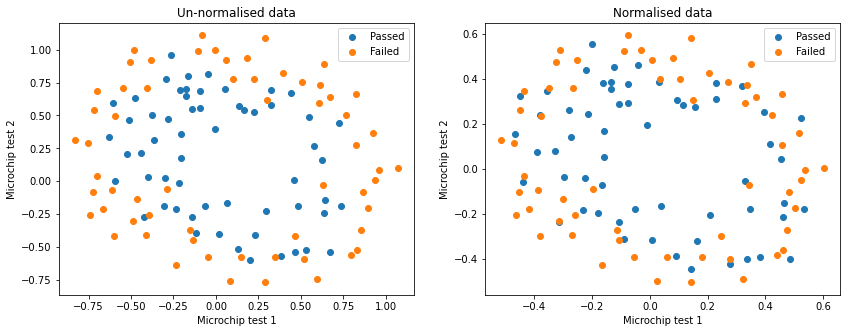

In [5]:
f = plt.figure()

f.set_figwidth(14)
f.set_figheight(5)

plt.subplot(1,2,1)
plt.title("Un-normalised data")
plt.scatter(admitted[:,0], admitted[:,1] , label="Passed")
plt.scatter(not_admitted[:,0], not_admitted[:,1], label="Failed")
plt.xlabel("Microchip test 1")
plt.ylabel("Microchip test 2")
plt.legend()

plt.subplot(1,2,2)
plt.title("Normalised data")
plt.scatter(_admitted[:,0], _admitted[:,1], label="Passed")
plt.scatter(_not_admitted[:,0], _not_admitted[:,1], label="Failed")
plt.xlabel("Microchip test 1")
plt.ylabel("Microchip test 2")
plt.legend()

### Featur Mapping - Increasing the number of features to get a better fit of Decision Boundary

In [6]:
def mapFeature(X1, X2):
    degree = 6
    out = np.ones(X.shape[0])[:,np.newaxis]
    for i in range(1, degree+1):
        for j in range(i+1):
            out = np.hstack((out, np.multiply(np.power(X1, i-j),                                     np.power(X2, j))[:,np.newaxis]))
    return out

X = mapFeature(X[:,1], X[:,2])
theta = np.array(np.zeros((X.shape[1],1)))
y.shape

(118, 1)

### The Hypothesis function

In [7]:
def _h(theta, X):
    z = np.dot(X,theta)
    
    return sigmoid(z)

def sigmoid(z):
    return 1/(1+np.exp(-z))

### Cost Function, gradient function & few utility functions

In [9]:
def cost_function(theta, X, y, lbd):
    # Computes the cost function for all the training samples
    
    z = np.dot(X,theta)       # theta-> 3 x 1; X-> m x 3
    h = 1/(1+np.exp(-z))      # h -> m x 1
    
    m = X.shape[0]
    cost = np.multiply(-y,np.log(h))- np.multiply((1-y),np.log(1-h))
    
    tmp = theta
    tmp[0] = 0
    
    reg = (lbd/(2*m)) * np.sum(np.power(tmp,2))
    
    J = (1/m)*np.sum(cost) + reg
    
    return J

def gradient(theta, x, y, lbd):
    # Computes the gradient of the cost function at the point theta
    m = x.shape[0]
    
    tmp = theta
    tmp[0] = 0
    
    reg = (lbd / m) * tmp
    
    return (1 / m) * np.dot(x.T, sigmoid(net_input(theta,   x)) - y) + reg

def lrGradientDescent(theta, X, y, lambda_t):
    m = len(y)
    grad = np.zeros([m,1])
    grad = (1/m) * X.T @ (sigmoid(X @ theta) - y)
    grad[1:] = grad[1:] + (lambda_t / m) * theta[1:]
    return grad

def net_input(theta, x):
    # Computes the weighted sum of inputs
    return np.dot(x, theta)

def probability(theta, x):
    # Returns the probability after passing through sigmoid
    return sigmoid(net_input(theta, x))

(27, 1)

### The Optimizer function
* fmin_tnc is an optimization solver that finds the minimum of an unconstrained function.
* For logistic regression, we want to optimize the cost function with the parameters theta.
* This is a faster method as compared to gradeint descent which might fail or take huge amounts
  of time for optimizing theta

In [15]:
'''
Arguements : 

1. The initial values of the parameters we are trying to optimize.----> x0
2. A function that, when given the training set and a particular
theta,computes the logistic regression cost and gradient with
respect to theta for the dataset (X, y).------------------------------> cost_function
3. Gradient of cost function -----------------------------------------> gradient
'''

def fit(x, y, theta, lbd):
    # Calls in-built optimization function to get optimal values for theta
    opt_weights = opt.fmin_tnc(func = cost_function, x0=theta, fprime = lrGradientDescent, args=(x, y.flatten(), lbd))
    
    return opt_weights

(m, n) = X.shape
y
theta = np.zeros((n,1))
lmbda = 70
J = cost_function(theta, X, y, lmbda)
print(J)

0.6931471805599454


### Initialising theta and calling "fit" function to get optimal theta values

In [14]:
theta = np.zeros((n,1))
output = fit(X,y,theta, lmbda)
#output = opt.fmin_tnc(func = cost_function, x0 = theta.flatten(), fprime = lrGradientDescent, \
#                         args = (X, y.flatten(), lmbda))
theta = output[0]

***
### Writing down hypothesis using our obtained optimal parameters
***

In [12]:
u = np.linspace(-1, 1.5, 50)
v = np.linspace(-1, 1.5, 50)
z = np.zeros((len(u), len(v)))
def mapFeatureForPlotting(X1, X2):
    degree = 6
    out = np.ones(1)
    for i in range(1, degree+1):
        for j in range(i+1):
            out = np.hstack((out, np.multiply(np.power(X1, i-j), np.power(X2, j))))
    return out
for i in range(len(u)):
    for j in range(len(v)):
        z[i,j] = np.dot(mapFeatureForPlotting(u[i], v[j]), theta)
        mask = y.flatten() == 1
        
X_t = X        
X_t = data.iloc[:,:-1]

### Seeing our Decision Boundary

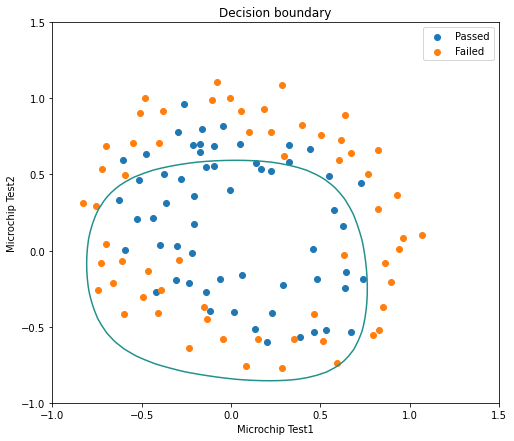

In [13]:
f = plt.figure()

f.set_figwidth(8)
f.set_figheight(7)
plt.title("Decision boundary")

passed = plt.scatter(X_t[mask][0], X_t[mask][1])
failed = plt.scatter(X_t[~mask][0], X_t[~mask][1])
plt.contour(u,v,z,0)
plt.xlabel('Microchip Test1')
plt.ylabel('Microchip Test2')
plt.legend((passed, failed), ('Passed', 'Failed'))
plt.show()

### Remarks - Got far better results in MATLAB